In [16]:
import pandas as pd
import plotnine as pn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import data

In [2]:
#Import Pooja's data
dat = pd.read_table("data/endpoint_data.txt")

#Import data from my old experiments
files = !ls data/plate*
file_list = []
for file in files:
    file_list.append(pd.read_table(file))
dat2 = pd.concat(file_list)

# Format data

In [3]:
#Filter data
#Keep only wells that that started at 0.05 OD and used 20ul of phage
dat2 = dat2.query("bacteria==0.05 & volume==20")

#Rename host column
dat = dat.rename(columns={"Host":"Strain"})

dat2 = dat2.replace({"Host\r\nControl":"Host Control"})

###################################
#Format phage strings
phages=["bop","car","ccs1","ccs2","ccs3","ump","carl","bill","ben","sds1","sds2","pg2","pg9","pg11","pg13","v12"]
phage_to_upper = {"bop":"Bop",
                 "car":"Car",
                 "ccs1":"CCS1",
                 "ccs2":"CCS2",
                 "ccs3":"CCS3",
                 "ump":"Ump",
                 "carl":"Carl",
                 "bill":"Bill",
                 "ben":"Ben",
                 "sds1":"SDS1",
                 "sds2":"SDS2",
                 "pg2":"PG2",
                 "pg9":"PG9",
                 "pg11":"PG11",
                 "pg13":"PG13",
                 "v12":"V12"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]

def parse_phages(text):
    '''
    Takes in a text string with phages in it and returns a list of the phages
    '''
    text_lower = str.lower(text)
    phage_list = []
    #Deal with car and carl
    if "carl" in text_lower:
        phage_list.append("carl")
        text_lower = text_lower.replace("carl","")
    for phage in phages:
        if phage in text_lower:
            phage_list.append(phage)
    phage_list = [phage_to_upper[x] for x in phage_list]
    return(phage_list)
       

dat["phage_list"] = dat.Phage.apply(func=parse_phages) 
dat2["phage_list"] = dat2.Phages.apply(func=parse_phages)    

###################################

#Subset columns to plot data
dat_format = dat.loc[:,["Strain","phage_list",'MOI 0.1','MOI 0.1.1','MOI 0.1.2']]\
    .melt(id_vars=["Strain","phage_list"])\
    .drop(columns="variable")

dat2_format = dat2.loc[:,["Strain","phage_list","value"]]

#Add in lab that performed experiment
dat_format["experimenter"] = "Pride"
dat2_format["experimenter"] = "Whiteson"

#Get bacteria only Pride wells
pride_positives = dat.loc[:,["Strain","Positive control","Positive control.1","Positive control.2"]]\
                    .melt(id_vars="Strain")\
                    .drop(columns="variable")
pride_positives["experimenter"] = "Pride"
pride_positives["phage_list"] = [[] for x in range(pride_positives.shape[0])]

#Merge data
dat_merged = pd.concat([dat_format, dat2_format,pride_positives])

#Add in phage count
dat_merged["phage_count"] = [len(x) for x in dat_merged.phage_list]

#Fromat phage string
dat_merged["phage_string"] = [','.join(x) for x in dat_merged.phage_list]

dat_merged = dat_merged.replace({"Yi6":"YI6"})

#Subtract media blank .107 taken from average of all negative wells
blank_val = .107
dat_merged["value"] = [x - blank_val for x in dat_merged["value"]]

dat_merged.head()

/anaconda3/envs/qiime2/lib/python3.6/site-packages/ipykernel_launcher.py:72: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Strain,experimenter,phage_list,value,phage_count,phage_string
0,YI6,Pride,[Bop],-0.0014,1,Bop
1,YI6,Pride,[Car],0.0674,1,Car
2,YI6,Pride,[CCS1],0.1690,1,CCS1
3,YI6,Pride,[CCS3],-0.0026,1,CCS3
4,YI6,Pride,[Ump],0.0150,1,Ump


_____

# Plot

Helper stuff

In [27]:
phage_type_dict = {"Bop":"M",
                 "Car":"M",
                 "CCS1":"M",
                 "CCS2":"S",
                 "CCS3":"S",
                 "Ump":"P",
                 "Carl":"M",
                 "Bill":"M",
                 "Ben":"M",
                 "SDS1":"S",
                 "SDS2":"S",
                 "PG2":"S",
                 "PG9":"S",
                 "PG11":"S",
                 "PG13":"S",
                 "V12":"M"}
color_dict = {"M":"blue",
             "S":"red",
             "P":"green"}

def format_phage_colors(phage_string, color_dict = color_dict):
    out_string = ''
    if phage_string=='' or phage_string=="phage_string":
        return(out_string)
    phage_list = phage_string.split(',')
    ordered_list = pd.Categorical(phage_list, categories= phage_order, ordered=True).sort_values().to_list()
    for phage in ordered_list:
        out_string += r'\textcolor{%s}{%s} ' % (color_dict[phage_type_dict[phage]], phage)
    return(out_string)
def order_pahge_string(phage_string):
    if phage_string=='' or phage_string=="phage_string":
        return('')
    phage_list = phage_string.split(',')
    ordered_list = pd.Categorical(phage_list, categories= phage_order, ordered=True).sort_values().to_list()
    return(' - '.join(ordered_list))

phage_types = {"Myoviridae":["V12","Bop","Ben","Bill","Car","Carl","CCS1"],
              "Siphoviridae":["CCS2","CCS3","SDS1","SDS2","PG2","PG9","PG11","PG13"],
              "Podoviridae":["Ump"]}
def make_boxplot(dat_merged,bac, number_titles=True):
    temp_dat=dat_merged.query('Strain==@bac')
    width_ratios = [len(set(temp_dat.query('phage_count==@pc').phage_string)) for pc in [0,1,2,3]]
    total_width = len(set(dat_merged.query('Strain==@bac').phage_string)) *.4
    colors=["white",'#a6cee3','#b2df8a','#fb9a99']
    fig,axs =  plt.subplots(1,4, figsize=(total_width,4), 
                            gridspec_kw={'width_ratios': width_ratios} )

    fig.subplots_adjust(wspace=.1)
    
    
    
    for n in [0,1,2,3]:
        axs[n].margins(x=2)
        data_subset= dat_merged.query('phage_count == @n & Strain == @bac')
        #Get phage order
        phage_order = data_subset.groupby("phage_string").agg({"value":"mean"}).sort_values("value").index
        
        #Grid
        axs[n].yaxis.grid(color='gray', linestyle='dashed')
        axs[n].set_axisbelow(True)
        
        sns.boxplot(data=data_subset,
                x= "phage_string",
                y="value",
                ax=axs[n],
                    width=.7,
                    fliersize=0,
                    order = phage_order,
                    hue="phage_count",
                    palette={x:c for x,c in zip([0,1,2,3],colors)})
              #  palette=["red","green","orange","blue"])

        sns.swarmplot(data=data_subset, 
                    x="phage_string", 
                    y="value", 
                    color="black",
                      order=phage_order,
                      size=3,
                      alpha=.6,
                    ax=axs[n])

        #Set y-limits
        axs[n].set_ylim(-.05,1)
        
        
        
        #Alter x labels
        labels = [order_pahge_string(item.get_text()) for item in axs[n].get_xticklabels()]
        axs[n].set_xticklabels(labels)
        for label in axs[n].get_xticklabels():
            label.set_ha("center")
            label.set_rotation(90)
        if n==0:
            axs[n].set_xticklabels(["No Phage"])
        #Axis y labels
        if n != 0:
            axs[n].set_yticklabels([])
        #Axis titles
        axs[n].set_xlabel('')
        if n==0:
            axs[n].set_ylabel('OD600 After 72 Hours', size=14)
        else:
            axs[n].set_ylabel('')
        #Plot titles
        if n==0:
            axs[n].set_title('')
        else:
            if number_titles:
                axs[n].set_title('{} Phages'.format(n), size=14)
        #Legend
        axs[n].get_legend().remove()

        for i,box in enumerate(axs[n].artists):
            box.set_edgecolor('black')
            #box.set_facecolor('white')

            for j in range(6*i,6*(i+1)):
                 axs[n].lines[j].set_color('black')
        

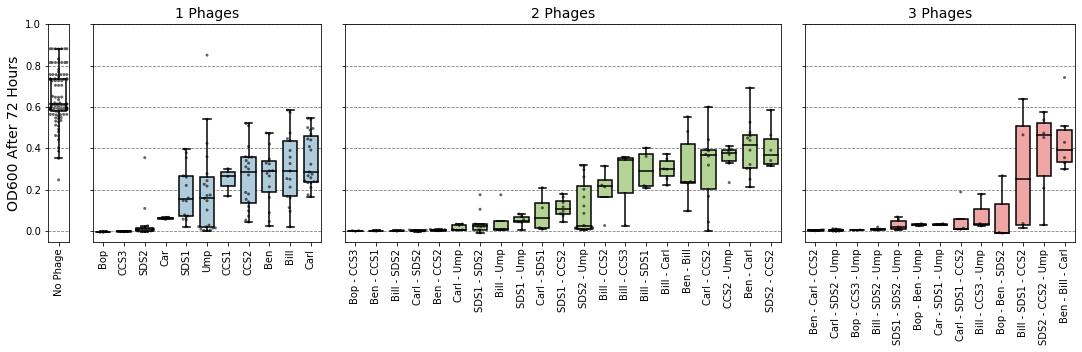

In [28]:
make_boxplot(dat_merged,"YI6")

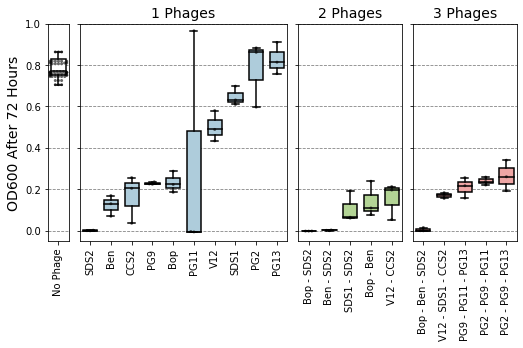

In [265]:
make_boxplot(dat_merged,"EF06")

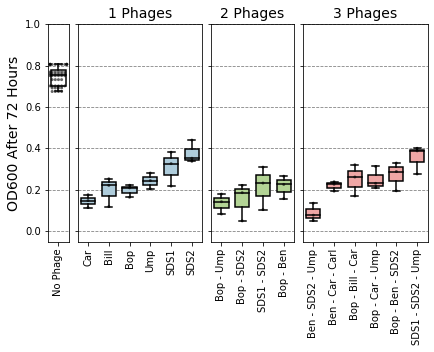

In [266]:
make_boxplot(dat_merged,"EF11")

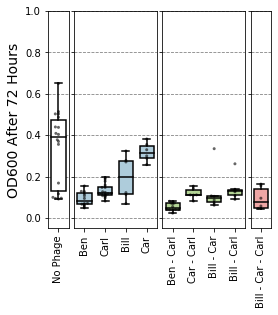

In [267]:
make_boxplot(dat_merged,"V587", number_titles=False)